# Analysis 

In this notebook we will take the data from the _Ego networks_ notebook and make an analysis with the three different methods: a multinomial logistic model, a random forest method an an artificial neural network. 
<br><br>
First, we will load the data, we will check for outliers and then we will prepare and format the predictors in order to apply each one of these methods. 
<br><br>
The first step is loading the libraries, in this case we will use the standard numpy, pandas, matplotlib and seaborn for manipulating and plotting the data. In order to apply the different techniques of analysis, we will use sklearn, statsmodels and tensorflow. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_validate, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
# Statsmodels
import statsmodels.formula.api as smf
from statsmodels.api import MNLogit



# Just to print prettier. Uncomment to see all (not important) warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Load data

The next step is loading the .csv file from the previous notebook. Then we will select the columns we will use for the analysis, as the notebook contains a lot of information of the egos not related to the structural properties of their networks. Then we will map the categorical columns to a numerical encoding in the columns of : _Subject origin_, _Subject residence_, and _Regime_. 

In [2]:
### Read data
df_2 = pd.read_csv('Redes_2_relg.csv')
### Drop Unnecessary Variables
df_2.drop('Unnamed: 0',axis=1, inplace=True)

###Take the necessary ones
df = df_2[df_2.columns[0:30]]
df['EDUC'] = df_2['EDUC'].copy()
df['FMIG2'] = df_2['FMIG2'].copy()
df['SEX'] = df_2['SEX'].copy()
df['RELG'] = df_2['RELG'].copy()

### The numerical encoding
#not_apply = ['Subject_origin','Subject_residence','Regime']
not_apply = ['Subject_origin','Subject_residence']
diccs = [0]*len(not_apply)
i = 0
for col in not_apply: 
        uniques = list(df[col].unique()) 
        diccs[i] = {uniques[j]:uniques.index(uniques[j]) for j in range(len(uniques)) }
        df[col] = df[col].map(diccs[i])
        i+=1
df.columns = df.columns.str.replace(' ', '_')
### Reset the datatype of the columns
df['Subject_origin'].astype('int64')
df['Subject_residence'].astype('int64')
#df['Regime'].astype('int64')


0      0
1      0
2      0
3      0
4      0
      ..
468    1
469    1
470    1
471    1
472    1
Name: Subject_residence, Length: 473, dtype: int64

## Prepare and explore data

We make an overview of the main statistics of the data and the properties we have generated in the past notebook.

In [3]:
df.describe(include='all')

,Subject_origin,Subject_residence,Mu,Regime,Average_degree,Betweenness,Closeness,Load_centrality,Assortativity,Clustering,...,Asmo,Arac,Asex,EGOFIRST,EGOLAST,SEX,BORN,EDUC,FMIG2,RELG
count,473.000000,473.000000,473.000000,473,473.000000,473.000000,473.000000,473.000000,473.000000,473.000000,...,473.000000,473.000000,473.000000,473,473,473.000000,473.000000,473.000000,473.000000,473.000000
unique,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,369,359,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,Unclear,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,jose,perez,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,222,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13,7,NaN,NaN,NaN,NaN,NaN
mean,4.997886,0.596195,-0.743170,NaN,23.921957,0.015319,0.687610,0.014895,-0.022917,0.640939,...,-0.088291,-0.153129,-0.009537,NaN,NaN,1.448203,3.014799,3.509514,3.634249,2.080338
std,2.781978,0.491179,13.524199,NaN,13.589893,0.011304,0.217223,0.011652,0.231357,0.168242,...,0.417944,0.577599,0.149704,NaN,NaN,0.497836,1.460567,1.432231,6.618497,0.665345
min,0.000000,0.000000,-294.081935,NaN,2.628571,0.000000,0.130665,0.000000,-2.000000,0.206979,...,-2.000000,-2.000000,-2.000000,NaN,NaN,1.000000,1.000000,1.000000,-1.000000,1.000000
25%,2.000000,0.000000,-0.299994,NaN,12.818182,0.006953,0.532497,0.005732,-0.136488,0.506595,...,-0.032954,-0.037886,-0.029268,NaN,NaN,1.000000,2.000000,2.000000,0.000000,2.000000
50%,5.000000,1.000000,-0.111711,NaN,19.066667,0.013948,0.632030,0.013860,-0.022727,0.661885,...,-0.022727,-0.022727,-0.022727,NaN,NaN,1.000000,2.000000,4.000000,1.000000,2.000000
75%,8.000000,1.000000,0.100436,NaN,40.666667,0.020487,0.938077,0.020487,0.018041,0.771862,...,0.006434,0.004354,0.013147,NaN,NaN,2.000000,4.000000,4.000000,4.000000,3.000000


Some values of `mu` are way out of range (min = -294). This is clearly from divergences in the model. We mark observations greater than 10 (in absolute value) as `nan` and then drop `nan`.

In [4]:
# Clean estimates for mu
df['Mu'] = df['Mu'].apply(lambda x: np.nan if x < -100 else x)
df['Mu'] = df['Mu'].apply(lambda x: np.nan if x > 100 else x)
df.dropna(inplace = True)

In [5]:
dicc_final = {1:"Other",2:"Christian",3:"Muslim"}

### Define `predictors` for all the inference and prediction methods 

In [6]:
predictors = ['Closeness','Clustering','Average_degree','Assortativity','Betweenness',
             'Closeness_origin','Closeness_residence','Number_origin','Number_residence','Mu',
             'Afrq','Aol2','Apro','Arel','Clos','Arac','Asex']
target = "RELG"

### Define `train` and `test` split for the dataset

In [7]:
X = df[predictors]       # independent variables
y = df[target]

test_size = 0.20 #maybe more is needed (20% is standard though)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 0)


# Standard Scaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform (X_test)

#Define dataframe as merge of X and y
df_str = df[target].to_frame().merge(pd.DataFrame(sc.fit_transform(X),columns=predictors,index=df.index), left_index=True, right_index=True)

# INFERENCE

At this point, we begin to include tools of inference, beginning by the multinomial logistic regression (MLN).
The library used for this analysis is mainly _statsmodels_ and the main function can be checked in this link:
https://stats.idre.ucla.edu/stata/dae/multinomiallogistic-regression/

In this part of the notebook we will prepare the variables, execute the regression and save the results. 

### Fit Multinomial Logistic Model

https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.MNLogit.html

In [8]:
### Uses the list 'predictors' as independent variables
formula_predictors = ' + '.join(predictors)
target_str = target +" ~ {}"
model = MNLogit.from_formula(target_str.format(formula_predictors), df_str)
results = model.fit(maxiter=200)

Optimization terminated successfully.
         Current function value: 0.800972
         Iterations 7


#### Results

In [9]:
print(results.summary())

                          MNLogit Regression Results                          
Dep. Variable:                   RELG   No. Observations:                  472
Model:                        MNLogit   Df Residuals:                      436
Method:                           MLE   Df Model:                           34
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:                  0.1913
Time:                        04:26:04   Log-Likelihood:                -378.06
converged:                       True   LL-Null:                       -467.51
Covariance Type:            nonrobust   LLR p-value:                 1.389e-21
             RELG=2       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.5445      0.175      8.845      0.000       1.202       1.887
Closeness              -0.4742      0.958     -0.495      0.621      -2.353       1.404
Clustering      

In [10]:
print('pseudo r-squared = {}'.format(np.round(results.prsquared,2)))

pseudo r-squared = 0.19


In [11]:
results.llr_pvalue

1.3889296381166788e-21

# PREDICTION

We train and fit a powerful non-linear (and non-parametric) machine learnin classifier to the data; a Random Forest. There are many other alternatives, but tree based metods are very powerfull and there are new techniques to help identify relevant predictors.

In this section, we want to test wether this model can outperform significantly other null (dummy) classifiers. If that is the case (which it is), it confirms the hypothesis that the predictors have relevant information about the nationalities of the subjects.

### Train and test with MNL regression

In [12]:

formula_predictors = ' + '.join(predictors)
model = MNLogit.from_formula(target_str.format(formula_predictors), df_str.loc[y_train.index])
results_prediction = model.fit(maxiter=200)
ypred = results_prediction.predict(df_str.loc[y_test.index])
y_pred =list(map(np.argmax,np.array(ypred)))
##Meter función accuracy 

Optimization terminated successfully.
         Current function value: 0.773547
         Iterations 7


In [13]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.23157894736842105


### Train and tune the model using k-cross fold validation

In [14]:
scoring = 'accuracy' #'f1_macro' # This chooses the metric to optimise during training (there are others!)
njobs=-1                         # This the number of cores used in your cpu (-1 means "all of them")
cv=5                             # the k in k-cross-fold validation
# RANDOM FOREST
print('\nFitting Random Forest\n')

rfc=RandomForestClassifier(random_state=0)
# Parameter combinations to explore
param_grid = { 
    'n_estimators': [75, 100,300,1000],
    'max_features': ['auto', None],
    'min_samples_split' :[2,6, 10, 14],
    'max_depth' : [10, 15, 30, 50,None],
    'max_samples' : [0.5 ,0.7, None],}


CV_rfc = GridSearchCV(estimator=rfc, 
                  param_grid=param_grid, 
                  scoring = scoring,
                  verbose=0,
                  n_jobs=njobs,
                  cv= cv)
CV_rfc.fit(X_train, y_train)

print('\nRandom Forest:')
print('Best Score: ', CV_rfc.best_score_)
print('Best Params: ', CV_rfc.best_params_)




Fitting Random Forest


Random Forest:
Best Score:  0.6367368421052632
Best Params:  {'max_depth': 10, 'max_features': None, 'max_samples': 0.5, 'min_samples_split': 10, 'n_estimators': 100}


### Evaluating the algorithm performance in the test set (unseen data)

In [15]:
y_pred = CV_rfc.predict(X_test)
print('Confusion Matrix:\n ', confusion_matrix(y_test,y_pred),'\n')
print(classification_report(y_test,y_pred),'\n')
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred),2))

Confusion Matrix:
  [[ 2 15  2]
 [ 2 43  5]
 [ 0 15 11]] 

              precision    recall  f1-score   support

           1       0.50      0.11      0.17        19
           2       0.59      0.86      0.70        50
           3       0.61      0.42      0.50        26

    accuracy                           0.59        95
   macro avg       0.57      0.46      0.46        95
weighted avg       0.58      0.59      0.54        95
 

Accuracy: 0.59


### Compare this performance with  null models

In [16]:
#  relative prevalence of each class
rel_prev = (y.value_counts() / len(y))
print(rel_prev)

2    0.552966
3    0.262712
1    0.184322
Name: RELG, dtype: float64


In [17]:
# Uniform Dummy Classifier (classifies randomly with p = 1/6)

# If the classifier randomly guesses: 
print('Acurracy of uniform dummy classifier: ',(((1/6) * y.value_counts()) / len(y)).sum()) # = 1/6

Acurracy of uniform dummy classifier:  0.16666666666666666


In [18]:
# Stratified Dummy Classifier (classifies randomly with p ~ prevalence of each class)
print('Acurracy of stratified dummy classifier: ',(rel_prev * y.value_counts()).sum() / len(y))

Acurracy of stratified dummy classifier:  0.4087636455041655


In [19]:
# Most frequent Dummy Classifier (classifies always in the most frequent class)
print('Acurracy of Most freq dummy classifier: ',rel_prev.max() )

Acurracy of Most freq dummy classifier:  0.5529661016949152


In [20]:
# SKLEARN versions of the dummy classifiers (to double check and for convinience methods)

dummy = "stratified"# most_frequent, stratified, uniform
dummy_clf = DummyClassifier(strategy=dummy,random_state=0) 

 

# Actual accuracy of the dummy in the same train-test split as the RF model
dummy_clf.fit(X_train, y_train)
dummy_score = dummy_clf.score(X_test, y_test)
print('Mean accuracy of null ' + dummy +' model: {0:.2f}'.format(dummy_score),'\n')
print('Mean accuracy (in test) of RF model: {0:.2f}'.format(CV_rfc.score(X_test, y_test)),'\n')




Mean accuracy of null stratified model: 0.39 

Mean accuracy (in test) of RF model: 0.59 



In [21]:
# Confusion matrix and report of the selected dummy classifier

y_pred_dummy = dummy_clf.predict(X_test)
print('Confusion Matrix:\n\n ',confusion_matrix(y_test,y_pred_dummy),'\n')
print(classification_report(y_test,y_pred_dummy),'\n')
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred_dummy),2))


Confusion Matrix:

  [[ 3 12  4]
 [ 6 27 17]
 [ 3 16  7]] 

              precision    recall  f1-score   support

           1       0.25      0.16      0.19        19
           2       0.49      0.54      0.51        50
           3       0.25      0.27      0.26        26

    accuracy                           0.39        95
   macro avg       0.33      0.32      0.32        95
weighted avg       0.38      0.39      0.38        95
 

Accuracy: 0.39


In [22]:
# Just for reference, the results of the RF Model

y_pred = CV_rfc.predict(X_test)
print('Confusion Matrix:\n\n ', confusion_matrix(y_test,y_pred),'\n')
print(classification_report(y_test,y_pred),'\n')
print('Accuracy: {0:.2f}'.format(accuracy_score(y_test, y_pred),2))

Confusion Matrix:

  [[ 2 15  2]
 [ 2 43  5]
 [ 0 15 11]] 

              precision    recall  f1-score   support

           1       0.50      0.11      0.17        19
           2       0.59      0.86      0.70        50
           3       0.61      0.42      0.50        26

    accuracy                           0.59        95
   macro avg       0.57      0.46      0.46        95
weighted avg       0.58      0.59      0.54        95
 

Accuracy: 0.59


In [23]:
dummy_report = pd.DataFrame(classification_report(y_test,dummy_clf.predict(X_test), output_dict= True))

rfc_report = pd.DataFrame(classification_report(y_test,CV_rfc.predict(X_test), output_dict= True))

#### Increase in prediction power (percentage with respect to null model)

i.e. 100% means twice as good

In [24]:
final_table = ((rfc_report - dummy_report)*100 / dummy_report).drop('support').round(decimals=2)
final_table

,1,2,3,accuracy,macro avg,weighted avg
precision,100.00,19.99,144.44,51.35,71.57,53.21
recall,-33.33,59.26,57.14,51.35,43.55,51.35
f1-score,-10.14,35.95,92.86,51.35,41.98,41.88


This significant increases further support the claim that the predictors (based on ego-network properties) have useful information to predict the countries of origin of the individuals)

## Shap Values

<ul>
  Shap values are a tool to interpret our random forest model, in this case. They tell us some intuition about which part of the prediction belongs to each feature. 
</ul>
<ul>
A positive (negative) SHAP value indicates that the value (in this case, probability of belonging to a certain country) is reinforced (diminished) by the feature.  
</ul>
<ul>
We will use 2 kind of plots at this moment. The first one one is a summary plot, a violin plot of the distribution of SHAP values. The colour indicates the value of the feature indicated at the left. This plot let us see the which features contribute the most (this is, they have high SHAP values). Features are ordered according to their contribution to the global prediction.
</ul>
<ul>
The second kind of plot you will see several times after the summary plot is the dependence plot. They show the distribution of the SHAP values of a variable. The colormap plots another variable, the one the algorithm thinks it has more interaction with the current variable. It lets us distinguish between different regimes of the coloured variable. 
</ul>

In [25]:
# explain the model's predictions using SHAP
##Shap values
import  shap

shap.initjs()
model = CV_rfc.best_estimator_
explainer = shap.TreeExplainer(model,X_train,check_additivity=False)
shap_values = explainer.shap_values(X_train,check_additivity=False)


## Example of summary plot

We extract the summary plots that summarizes the correlations for each nationality.

<u>SHAP values for the control group</u>

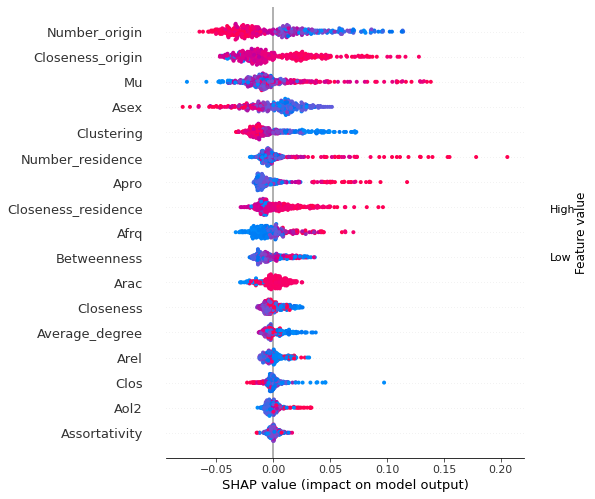

In [26]:
shap.summary_plot(shap_values[0],X_train,feature_names = predictors)

<u>SHAP values for the christians</u>

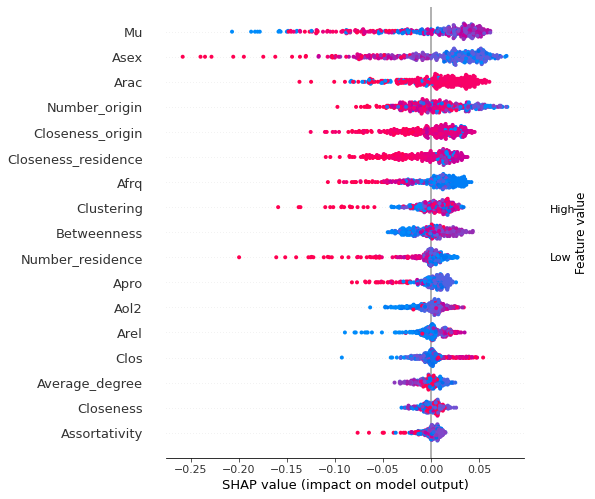

In [27]:
shap.summary_plot(shap_values[1],X_train,feature_names = predictors)

<u>SHAP values for the muslims</u>

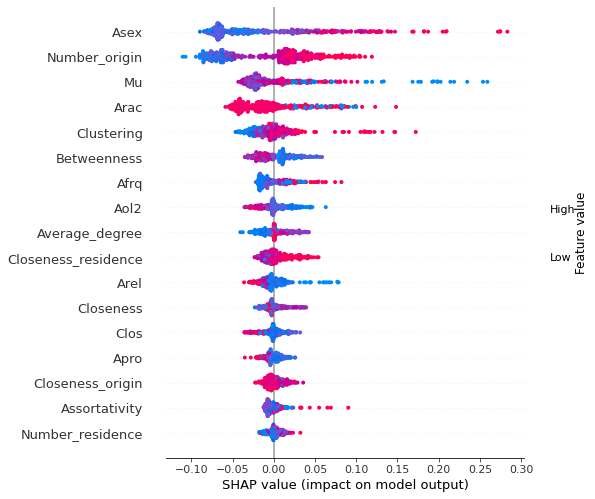

In [28]:
shap.summary_plot(shap_values[2],X_train,feature_names = predictors)

# LIME 

<ul>
LIME (Local Interpretable Model-agnostic Explanations), is an algorithm that takes the decision function from the classifier (decision = f(features)). This function may be complex, but the algorithm makes a linear regression around a single prediction, weighting the importance of the coefficients with the distance to this local prediction.   
</ul>
<ul>
This kind of algorithm helps us to explain single predictions.
</ul>

In [29]:
##Using LIME to interpret 
import lime
import lime.lime_tabular

In [30]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=predictors, discretize_continuous=True)

In [31]:
i = np.random.randint(0, X_test.shape[0])
exp = explainer.explain_instance(X_test[i], CV_rfc.predict_proba, num_features=3, top_labels=1)

In [32]:
exp.show_in_notebook(show_table=True, show_all=True)

##  Artificial neural network

As a complementary method, we train a simple ANN to provide a new method and give more strength to the previous results. In order to do that, we will preprocess the data, distinguishing the categorical and numerical predictors. Then we will split the dataset into the train and test parts and, finally, we will define the model and fit to obtain a final result for the accuracy. 

In [33]:
### Import the package tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import tensorflow as tf

tf.random.set_seed(0)

In [37]:
###Define  a simple a ANN and fit our data
stat_accul = []
model_accul = tf.keras.Sequential([
    tf.keras.layers.Dense(70,activation="relu"),
    tf.keras.layers.Dense(70,activation="relu"),
    tf.keras.layers.Dense(70,activation="relu"),
    tf.keras.layers.Dense(4,activation="softmax")
])



###Compile the model 
model_accul.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
               optimizer=tf.keras.optimizers.Adam(learning_rate=10e-4),
               metrics=["accuracy"])

### We fit the model 100 times and take notes of the accuracy on the test set

history_accul = model_accul.fit(X_train,
                         np.array(y_train),
                         epochs=100,
                         verbose = 0)
stat_accul.append(model_accul.evaluate(X_test,np.array(y_test))[1])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on

## Display the final results

In [38]:
print(f"The final results for a training iteration is {np.average(stat_accul):.2f}")

The final results for a training iteration is 0.55
